In [1]:
import torch
import lovely_tensors as lt
lt.monkey_patch()

## Notebook objectives
1. Build a logistic regression model with torch.
2. Code up a loss function.
3. Bring parity with torch's built-in loss functions.

# Define the logistic regression model

In [2]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
# class Logistic(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(NeuralNet, self).__init__()
#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(input_dim, hidden_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_dim, output_dim)
#         )

#     def forward(self, x):
#         return self.layers(x)

In [4]:
input_dim = 10
hidden_dim = 5
output_dim = 1
n_samples = 25

# Creating a sample train, val and test dataset

In [5]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


# Run the forward pass with custom loss function

In [6]:
# from torchinfo import summary

# model = NeuralNet(input_dim=10, hidden_dim=5, output_dim=1)
# summary(model, input_size=(1, 10))

In [7]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

def criterion(logits, actuals):
    e = 1e-8
    probs = torch.sigmoid(logits.squeeze())
    loss = - actuals * (probs + e).log() - (1 - actuals) * ((1 - probs) + e).log()
    loss = loss.mean()
    return loss

torch.manual_seed(42)
clf = LogisticRegression(input_dim, output_dim)

optimizer = torch.optim.SGD(clf.parameters(), lr=0.01)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)

    loss = criterion(y_pred, train_y.float())
    # loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds, val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:03d}/{n_epochs:03d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch: 000/020 | train_loss:  0.699961 | val_loss:  0.633116
 epoch: 001/020 | train_loss:  0.698127 | val_loss:  0.633783
 epoch: 002/020 | train_loss:  0.696303 | val_loss:  0.634453
 epoch: 003/020 | train_loss:  0.694489 | val_loss:  0.635124
 epoch: 004/020 | train_loss:  0.692684 | val_loss:  0.635798
 epoch: 005/020 | train_loss:  0.690890 | val_loss:  0.636473
 epoch: 006/020 | train_loss:  0.689106 | val_loss:  0.637151
 epoch: 007/020 | train_loss:  0.687332 | val_loss:  0.637831
 epoch: 008/020 | train_loss:  0.685568 | val_loss:  0.638512
 epoch: 009/020 | train_loss:  0.683814 | val_loss:  0.639196
 epoch: 010/020 | train_loss:  0.682069 | val_loss:  0.639882
 epoch: 011/020 | train_loss:  0.680334 | val_loss:  0.640569
 epoch: 012/020 | train_loss:  0.678609 | val_loss:  0.641259
 epoch: 013/020 | train_loss:  0.676893 | val_loss:  0.641950
 epoch: 014/020 | train_loss:  0.675187 | val_loss:  0.642644
 epoch: 015/020 | train_loss:  0.673490 | val_loss:  0.643339
 epoch: 

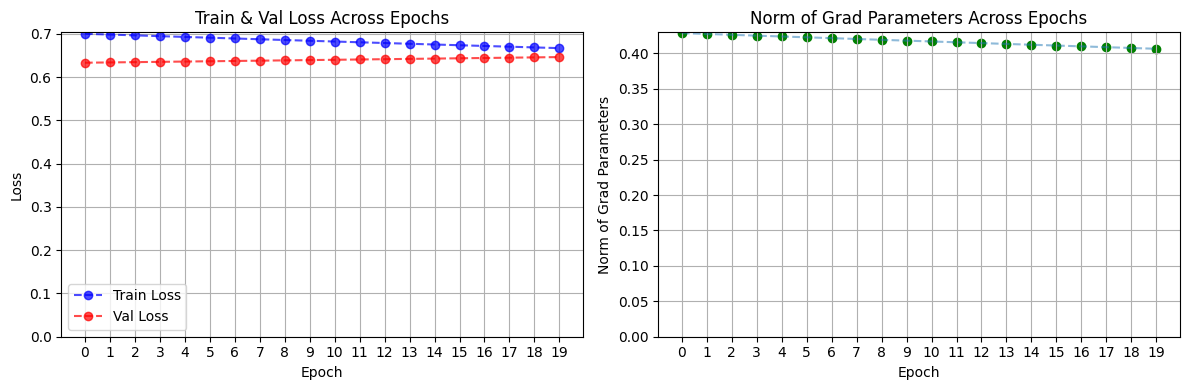

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# Plot gradient norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Grad Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_ylim(bottom=0)  # Start y-axis from zero
axes[1].grid(True)

plt.tight_layout()
plt.show()


## PyTorch way!

In [9]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

torch.manual_seed(42)
clf = LogisticRegression(input_dim, output_dim)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(clf.parameters(), lr=0.001)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:03d}/{n_epochs:03d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch: 000/020 | train_loss:  0.699961 | val_loss:  0.633116
 epoch: 001/020 | train_loss:  0.698127 | val_loss:  0.633783
 epoch: 002/020 | train_loss:  0.696303 | val_loss:  0.634452
 epoch: 003/020 | train_loss:  0.694489 | val_loss:  0.635124
 epoch: 004/020 | train_loss:  0.692684 | val_loss:  0.635798
 epoch: 005/020 | train_loss:  0.690890 | val_loss:  0.636473
 epoch: 006/020 | train_loss:  0.689106 | val_loss:  0.637151
 epoch: 007/020 | train_loss:  0.687332 | val_loss:  0.637831
 epoch: 008/020 | train_loss:  0.685568 | val_loss:  0.638512
 epoch: 009/020 | train_loss:  0.683814 | val_loss:  0.639196
 epoch: 010/020 | train_loss:  0.682069 | val_loss:  0.639882
 epoch: 011/020 | train_loss:  0.680334 | val_loss:  0.640569
 epoch: 012/020 | train_loss:  0.678609 | val_loss:  0.641259
 epoch: 013/020 | train_loss:  0.676893 | val_loss:  0.641950
 epoch: 014/020 | train_loss:  0.675187 | val_loss:  0.642643
 epoch: 015/020 | train_loss:  0.673490 | val_loss:  0.643339
 epoch: 

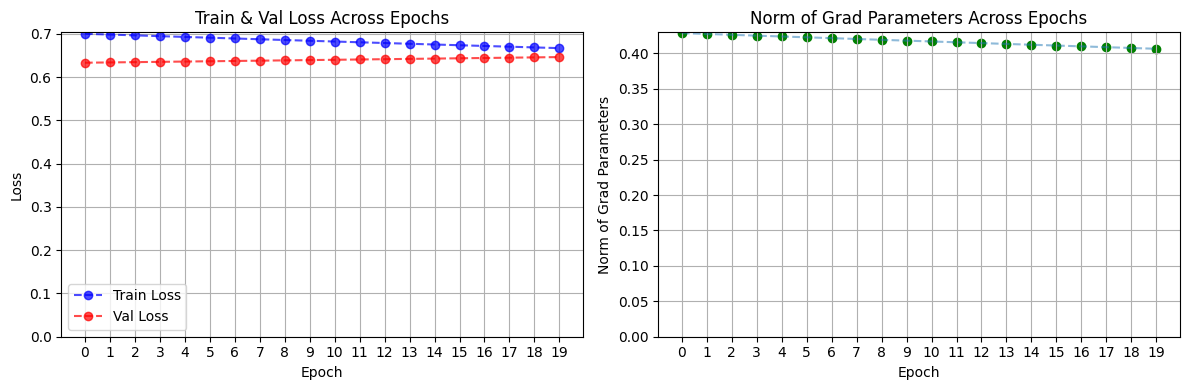

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# Plot gradient norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Grad Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_ylim(bottom=0)  # Start y-axis from zero
axes[1].grid(True)

plt.tight_layout()
plt.show()


The loss values look exactly the same! Yay!

BCEWithLogitsLoss takes inputs which are logits that are not converted to probabilities yet. This loss function internally converts the logits to probabibilities and then computes the logistic loss. This is more numerically stable!